# Import packages

In [8]:
import pandas as pd
import numpy as np
import os
from anndata import read_h5ad
from sklearn.neighbors import NearestNeighbors


import warnings
warnings.filterwarnings('ignore')
import sys

# sys.path.append('/data/yosef2/users/chenling/scVI/')
sys.path.append('../../utils/')
from annotations_utils import *
import scvi
print(scvi.__version__)

import os
os.getcwd()

import logging
import os
import pickle
from MulticoreTSNE import MulticoreTSNE as TSNE

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from hyperopt import hp

from scvi.inference import UnsupervisedTrainer, AlternateSemiSupervisedTrainer, SemiSupervisedTrainer
from scvi.models import VAE, SCANVI
from copy import deepcopy

from scvi.dataset.anndataset import AnnDatasetFromAnnData

import scanpy as sc
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)

from anndata import read_h5ad
from anndata import AnnData

import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline

n_epochs = 150
show_plot = True
test_mode = False
use_batches = True
use_cuda = True
lr = 1e-3
retrain=True


sc.logging.print_versions()

[2020-02-13 10:36:05,110] INFO - scvi._settings | Added StreamHandler with custom formatter to 'scvi' logger.


0.5.0
scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.3.1 pandas==0.25.1 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


# Load data

In [2]:
rawdata_path = '../../data-objs/pilot1/'
tenx = read_h5ad(rawdata_path + 'tabula-sapiens-10X-pilot-filtered.h5ad')
ss2 = read_h5ad(rawdata_path + 'tabula-sapiens-facs-pilot-filtered.h5ad')
raw = tenx.concatenate(ss2)
raw.obs.index = [x[:-2] for x in raw.obs.index]

In [3]:
ann = []
for tissue in ['blood', 'pancreas','bladder','lung', 'muscle']:
    data = read_h5ad('CombineCompartments.scANVI.%s.h5ad'%tissue)
    ann.append(data.obs)
    


In [4]:
ann[0]['pred_by_compartment'] = ann[0]['pred2']
ann[0]['pred_by_compartment_alternate'] = ann[0]['pred2_alternate']
ann[0]['smooth_comp'] = 'Immune'
ann[0].loc[ann[0]['pred2']=='pancreas','smooth_comp']='pancreas'

ann[1]['pred_by_compartment'] = ann[1]['pred2']
ann[1]['pred_by_compartment_alternate'] = ann[1]['pred2_alternate']


for i in [0,2,3,4]:
    ann[i].index = [x[:-2] for x in ann[i].index]

In [5]:
ann = pd.concat(ann, axis=0, sort=False)

In [6]:
np.unique(ann.loc[ann['tissue']=='Blood','smooth_comp'],return_counts=True)

(array(['Immune', 'pancreas'], dtype=object), array([251,  26]))

In [7]:
ann = ann[['10X_plate', 'input_ann2','pred2', 
       'smooth_comp', 'pred_by_compartment','tissue', 
        'pred2_alternate', 'pred_by_compartment_alternate' ]]

In [8]:
temp = pd.concat([raw.obs[['batch']], ann], axis=1, sort=False)
temp['input_ann2'].fillna('unassigned', inplace=True)
temp['smooth_comp'].fillna('nan', inplace=True)

assert np.sum(raw.obs.index == temp.index)==len(temp.index)
raw.obs = temp

In [9]:
tissue_tech = [x + ['_10x','_ss2'][int(y)] for x,y in zip(raw.obs['tissue'].values, raw.obs['batch'].values)]

raw.obs['batch'] = tissue_tech
_, raw.obs['batch_id'] = np.unique(tissue_tech,return_inverse=True)

In [10]:
all_dataset = AnnDatasetFromAnnData(raw, 'batch_id')

[2020-02-11 11:36:33,118] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-02-11 11:36:33,127] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-02-11 11:36:34,622] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-02-11 11:36:36,260] INFO - scvi.dataset.dataset | Downsampled from 68451 to 68451 cells


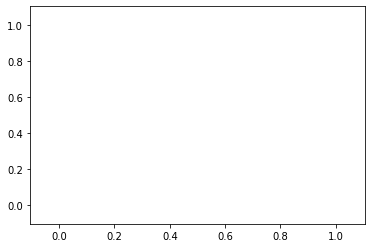

In [11]:
model_file = 'AnnotationFinal.scVI.pkl'
posterior = get_scvi_posterior(all_dataset, model_file)
latent, _, _ = posterior.get_latent()

# Regenerating Compartment Prediction

In [12]:
compartment_pred = pd.read_csv('compartment_seeds_prediction.csv',index_col=0)
raw.obs = pd.concat([compartment_pred['predicted'],raw.obs], axis=1)
raw.obs.rename_axis({'predicted':'Compartment Prediction'}, inplace=True, axis=1)

In [13]:
pancreas_pred = pd.read_csv('pancreas_seeds_prediction.csv',index_col=0)
raw.obs = pd.concat([pancreas_pred['predicted'], raw.obs], axis=1)
raw.obs.rename_axis({'predicted':'Pancreas Prediction'}, inplace=True, axis=1)

# using scVI latent space in scanpy

In [14]:
raw.obsm["X_scvi"] = latent
sc.pp.neighbors(raw, n_neighbors=20, n_pcs=30, use_rep="X_scvi")
sc.tl.umap(raw)

In [15]:
sc.tl.tsne(raw, use_rep = 'X_scvi')

In [16]:
X = raw.obsm['X_scvi']
nbrs = NearestNeighbors(n_neighbors=30).fit(X)
distances, indices = nbrs.kneighbors(X)

In [17]:
smooth_comp = []
compartments = deepcopy(raw.obs['Compartment Prediction'].values.astype(str))
for i,x in enumerate(compartments):
    res = clustercomp(compartments[indices[i][1:]])
    smooth_comp.append(res)
    

In [18]:
raw.obs['smooth_comp2'] = smooth_comp

... storing 'Pancreas Prediction' as categorical
... storing 'Compartment Prediction' as categorical
... storing 'batch' as categorical
... storing 'input_ann2' as categorical
... storing 'pred2' as categorical
... storing 'smooth_comp' as categorical
... storing 'pred_by_compartment' as categorical
... storing 'tissue' as categorical
... storing 'pred2_alternate' as categorical
... storing 'pred_by_compartment_alternate' as categorical
... storing 'smooth_comp2' as categorical


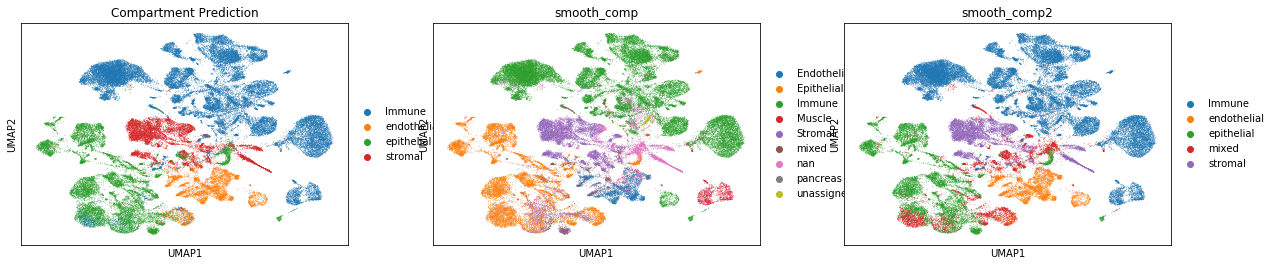

In [19]:
sc.pl.umap(raw, color=['Compartment Prediction','smooth_comp', 'smooth_comp2'])

# plotting cell cycle changes

In [20]:
g1s_genes =  ['MCM5','PCNA','TYMS','FEN1','MCM2','MCM4','RRM1','UNG','GINS2','MCM6','CDCA7','DTL','PRIM1','UHRF1','MLF1IP','HELLS','RFC2','RPA2','NASP',
         'RAD51AP1','GMNN','WDR76','SLBP','CCNE2','UBR7','POLD3','MSH2','ATAD2','RAD51','RRM2','CDC45','CDC6','EXO1','TIPIN','DSCC1','BLM','CASP8AP2',
         'USP1','CLSPN','POLA1','CHAF1B','BRIP1','E2F8']

g2m_genes = ['HMGB2','CDK1','NUSAP1','UBE2C','BIRC5','TPX2','TOP2A','NDC80','CKS2','NUF2','CKS1B','MKI67','TMPO','CENPF','TACC3','FAM64A','SMC4','CCNB2',
        'CKAP2L','CKAP2','AURKB','BUB1','KIF11','ANP32E','TUBB4B','GTSE1','KIF20B','HJURP','HJURP','CDCA3','HN1','CDC20','TTK','CDC25C','KIF2C',
        'RANGAP1','NCAPD2','DLGAP5','CDCA2','CDCA8','ECT2','KIF23','HMMR','AURKA','PSRC1','ANLN','LBR','CKAP5','CENPE','CTCF','NEK2','G2E3','GAS2L3',
        'CBX5','CENPA']


In [21]:
sc.tl.score_genes_cell_cycle(raw, s_genes=g1s_genes, g2m_genes=g2m_genes)


# find cell ontology terms for all cell types

In [22]:
# np.unique(raw.obs[raw.obs['input_ann2']=='Intermediate']['tissue'])
# np.unique(raw.obs[raw.obs['input_ann2']=='Intermediate']['smooth_comp'])

In [23]:
celltype_dict = {'Adventitious_Fibroblast': 'CL:0002503',
 'Airway_Smooth_Muscle': 'CL:0002598',
 'Alveolar_Fibroblast': 'CL:0002553',
 'Artery': 'CL:1000413',
 'B_cell': 'CL:0000236',
 'Basal': 'CL:0000646',
 'Basophil': 'CL:0000767',
 'Bronchial Vessel': 'CL:2000016',
 'CD4': 'CL:0000624',
 'CD4_Naive': 'CL:0000895',
 'CD4_memory': 'CL:0000897',
 'CD4_memory_effector': 'CL:0000897',
 'CD4_naive': 'CL:0000895',
 'CD8': 'CL:0000625',
 'CD8_Effector': 'CL:0000913',
 'CD8_Naive': 'CL:0000900',
 'CD8_memory_effector': 'CL:0000913',
 'CD8_naive': 'CL:0000900',
 'Capillary': 'CL:0002144',
 'Capillary Intermediate 1': 'CL:0002144',
 'Capillary Intermediate 2': 'CL:0002144',
 'Capillary_Aerocyte': 'CL:0002144',
 'Ciliated': 'CL:1000271',
 'Classical_monocyte': 'CL:0000860',
 'Club': 'CL:0000158',
 'Dendritic_cell': 'CL:0001056',
 'EREG_dendritic': 'CL:0001056',
 'Endothelial': 'CL:0000115',
 'Fibroblast': 'CL:0000057',
 'Goblet': 'CL:0002370',
 'IGSF21_dendritic': 'CL:0001056',
 'Intermediate': 'CL:1001428',
 'Islet_PP': 'CL:0002275',
 'Islet_beta': 'CL:0000169',
 'Islet_delta': 'CL:0000173',
 'Lymphatic': 'CL:0002138',
 'Macrophage': 'CL:0000235',
 'MastCells': 'CL:0000097',
 'Mast_Cell': 'CL:0000097',
 'Mast_cell': 'CL:0000097',
 'MesenchymalStemCells': 'CL:0000134',
 'MuscleFiberFrag': 'CL:0008002',
 'MuscleStemCells': 'CL:0000355',
 'Myoblast': 'CL:0000056',
 'Myofibroblast': 'CL:0000186',
 'NK': 'CL:0000623',
 'NKT_cell': 'CL:0000814',
 'Natural_Killer_T': 'CL:0000814',
 'Neutrophil': 'CL:0000775',
 'Plasma_cell': 'CL:0000786',
 'RBC': 'CL:0000232',
 'SmoothMuscleCells': 'CL:0000192',
 'Smooth_muscle': 'CL:0000192',
 'TREM_Dendritic': 'CL:0001056',
 'T_cell': 'CL:0000084',
 'Tenocyte': 'CL:0000388',
 'Vascular_Smooth_Muscle': 'CL:0000359',
 'Vascular_smooth_muscle': 'CL:0000359',
 'Vein': 'CL:0002543',
 'Vessel': 'CL:0002139',
 'acinar': 'CL:0002064',
 'alveolar_epithelial_1': 'CL:0002062',
 'alveolar_epithelial_2': 'CL:0002063',
 'classical_monocyte': 'CL:0000860',
 'ductal': 'CL:0002079',
 'endothelial': 'CL:0000115',
 'immune_endocrine_doublet': 'CL:0000000',
 'intermediate_monocyte': 'CL:0002393',
 'islet_alpha': 'CL:0000171',
 'low_quality': 'CL:0000000',
 'macrophage': 'CL:0000235',
 'macrophage_basophil_doublets': 'CL:0000000',
 'mast_cell': 'CL:0000097',
 'megakaryocyte': 'CL:0000556',
 'myeloid_dendritic_1': 'CL:0001057',
 'myeloid_dendritic_2': 'CL:0001057',
 'myofibroblast': 'CL:0000186',
 'natural_killer': 'CL:0000623',
 'neutrophil': 'CL:0000775',
 'non_classical_monocyte': 'CL:0000875',
 'nonclassical_monocyte': 'CL:0000875',
 'pDC': 'CL:0001058',
 'pancreas': 'CL:0000083',
 'pericyte': 'CL:0000669',
 'plasma': 'CL:0000786',
 'plasmacytoid_dendritic': 'CL:0001058',
 'signaling_aveolar_epithelium': 'CL:0010003',
 'stellate_cell': 'CL:0002410',
 'unassigned': 'CL:0000000',
'nan': 'CL:0000000'}

In [24]:
from networkx import descendants, ancestors
import obonet

obo = '../data/cl.obo.txt'
f = open(obo, "r")
co = obonet.read_obo(f)
f.close()

In [25]:
free_ann_list = ['Alveolar_Fibroblast',  'Capillary Intermediate 1',  
                 'Capillary Intermediate 2',  'Capillary_Aerocyte',  
                 'EREG_dendritic',  'IGSF21_dendritic',  'Intermediate', 
                 'TREM_Dendritic',  'immune_endocrine_doublet',  'low_quality',  'macrophage_basophil_doublets', 
                 'myeloid_dendritic_1',  'myeloid_dendritic_2',  'signaling_aveolar_epithelium', 'unassigned','nan']

In [26]:
raw.obs.columns

Index(['Pancreas Prediction', 'Compartment Prediction', 'batch', '10X_plate',
       'input_ann2', 'pred2', 'smooth_comp', 'pred_by_compartment', 'tissue',
       'pred2_alternate', 'pred_by_compartment_alternate', 'batch_id',
       'smooth_comp2', 'S_score', 'G2M_score', 'phase'],
      dtype='object')

In [27]:
raw.obs

,Pancreas Prediction,Compartment Prediction,batch,10X_plate,input_ann2,pred2,smooth_comp,pred_by_compartment,tissue,pred2_alternate,pred_by_compartment_alternate,batch_id,smooth_comp2,S_score,G2M_score,phase
index,,,,,,,,,,,,,,,,
AAACGAAAGCATCCCG-1-0,not pancreas,epithelial,endopancreas_10x,1,unassigned,ductal,Epithelial,ductal,endopancreas,ductal,ductal,8,epithelial,0.004405,-0.043050,S
AAAGGATTCTCGCCTA-1-0,pancreas,epithelial,endopancreas_10x,1,unassigned,acinar,mixed,acinar,endopancreas,acinar,acinar,8,epithelial,0.010873,-0.035670,S
AAAGGGCGTGGGCTCT-1-0,pancreas,epithelial,endopancreas_10x,1,acinar,acinar,Stromal,acinar,endopancreas,acinar,acinar,8,mixed,-0.009056,-0.029520,G1
AACAAAGTCGAAGCCC-1-0,pancreas,epithelial,endopancreas_10x,1,acinar,acinar,Epithelial,acinar,endopancreas,ductal,ductal,8,epithelial,-0.015524,-0.014692,G1
AACAACCTCAACGAGG-1-0,not pancreas,endothelial,endopancreas_10x,1,Endothelial,Endothelial,mixed,Endothelial,endopancreas,Endothelial,Endothelial,8,endothelial,-0.025596,-0.106806,G1
AACAACCTCTTCCGTG-1-0,not pancreas,epithelial,endopancreas_10x,1,unassigned,ductal,Epithelial,ductal,endopancreas,ductal,ductal,8,epithelial,-0.028461,-0.028222,G1
AACACACCATGGAAGC-1-0,not pancreas,Immune,endopancreas_10x,1,unassigned,Endothelial,Immune,Endothelial,endopancreas,B_cell,B_cell,8,Immune,0.017341,-0.020910,S
AACAGGGTCGACGTCG-1-0,not pancreas,endothelial,endopancreas_10x,1,Endothelial,Endothelial,Endothelial,Endothelial,endopancreas,Endothelial,Endothelial,8,endothelial,-0.101121,-0.475468,G1
AACCTGATCGTCCATC-1-0,pancreas,epithelial,endopancreas_10x,1,acinar,acinar,mixed,acinar,endopancreas,acinar,acinar,8,epithelial,-0.009056,-0.018450,G1


# for actual ontology terms

In [ ]:
# for c in ['pred2','pred2_alternate','pred_by_compartment','pred_by_compartment_alternate', 'input_ann2']:
#     ont = []
#     new = []
#     for x in raw.obs[c]:
#         ont.append(celltype_dict[x])
#         if x in free_ann_list:
#             new.append(x)
#         else: 
#             new.append(co.nodes[celltype_dict[x]]['name'])
#     print(raw.obs.shape, len(new))
#     raw.obs[c] = new
#     raw.obs[c+'_ontology'] = ont

In [ ]:
# raw[raw.obs['input_ann2']=='unassigned'].write_h5ad('CombineCompartments.scANVI.all.count.unlabelled.h5ad')

In [ ]:
# raw[raw.obs['input_ann2']!='unassigned'].write_h5ad('CombineCompartments.scANVI.all.count.labelled.h5ad')

In [ ]:
# np.sum(raw.obs['input_ann2']=='unassigned')

# for cell type names in ontology

In [29]:
for c in ['pred2','pred2_alternate','pred_by_compartment','pred_by_compartment_alternate', 'input_ann2']:
    ont = []
    new = []
    for x in raw.obs[c]:
        ont.append(co.nodes[celltype_dict[x]]['name'])
        if x in free_ann_list:
            new.append(x)
        else: 
            new.append(co.nodes[celltype_dict[x]]['name'])
    print(raw.obs.shape, len(new))
    raw.obs[c] = new
    raw.obs[c+'_ontology'] = ont

(68451, 16) 68451
(68451, 17) 68451
(68451, 18) 68451
(68451, 19) 68451
(68451, 20) 68451


# cell type frequency summaries

In [30]:
len(np.unique(raw.obs['input_ann2_ontology']))

60

In [31]:
len(np.unique(raw.obs['pred2_ontology']))

59

In [32]:
# missing = [x for x in np.unique(raw.obs['input_ann2']) 
#            if x not in np.unique(raw.obs['pred_by_compartment_alternate']) and x != 'unassigned']
# missing10x = [x for x in np.unique(raw.obs['input_ann2']) 
#               if x not in np.unique(np.asarray(raw.obs['pred_by_compartment_alternate'])[raw.obs['10X_plate']!='nan']) and x != 'unassigned']
# missingss2 = [x for x in np.unique(raw.obs['input_ann2']) 
#               if x not in np.unique(np.asarray(raw.obs['pred_by_compartment_alternate'])[raw.obs['10X_plate']=='nan']) and x != 'unassigned']
# print( "%s missing,\n %s missing from 10x,\n %s missing from Smartseq2" %
#       (", ".join(missing), ", ".join(missing10x), ", ".join(missingss2)))

In [33]:
qc = sc.pp.calculate_qc_metrics(raw)[0]

In [34]:
raw.obs['n_genes'] = qc['n_genes_by_counts']

In [35]:
raw.obs['log1p_total_counts'] = qc['log1p_total_counts']

In [36]:
raw.obs.rename(inplace=True, columns={"batch": "Tissue Tech","smooth_comp":"Compartment",
                "input_ann2": "Manual Annotation Round 2","smooth_comp2": "Smoothed Compartment Prediction",
                "input_ann2_ontology": "Manual Annotation Round 2 Ontology Terms",
                "pred2":"scANVI Prediction By Organ", "pred2_alternate":"scANVI Prediction By Organ with Alternate Training",
                "pred_by_compartment":"scANVI Prediction By Organ-Compartment",
                "pred_by_compartment_alternate":"scANVI Prediction By Organ-Compartment with Alternate Training",
                "pred2_ontology":"scANVI Prediction Ontology Term By Organ", 
                "pred2_alternate_ontology":"scANVI Prediction Ontology Term By Organ with Alternate Training",
                "pred_by_compartment_ontology":"scANVI Prediction Ontology Term By Organ-Compartment",
                "pred_by_compartment_alternate_ontology":"scANVI Prediction Ontology Term By Organ-Compartment with Alternate Training"})

# saving objects 

In [38]:
raw.obs['tissue'].replace('bladder','Bladder', inplace=True)
raw.obs['tissue'].replace('blood','Blood', inplace=True)
raw.obs['tissue'].replace('lung','Lung', inplace=True)
raw.obs['tissue'].replace('muscle','Muscle', inplace=True)
raw.obs['tissue'].replace('endopancreas','Pancreas', inplace=True)
raw.obs['tissue'].replace('PancreasEndocrine','Pancreas', inplace=True)
raw.obs['tissue'].replace('PancreasExocrine','Pancreas', inplace=True)
raw.obs['tissue'].replace('exopancreas1','Pancreas', inplace=True)
raw.obs['tissue'].replace('exopancreas2','Pancreas', inplace=True)

In [39]:
print("\n".join(free_ann_list))

Alveolar_Fibroblast
Capillary Intermediate 1
Capillary Intermediate 2
Capillary_Aerocyte
EREG_dendritic
IGSF21_dendritic
Intermediate
TREM_Dendritic
immune_endocrine_doublet
low_quality
macrophage_basophil_doublets
myeloid_dendritic_1
myeloid_dendritic_2
signaling_aveolar_epithelium
unassigned
nan


In [40]:
sc.tl.leiden(raw, resolution=5)

In [41]:
imputed = posterior.sequential().imputation(transform_batch=6)

In [42]:
imputed = np.log1p(imputed)

In [43]:
imputed_adata = deepcopy(raw)
imputed_adata.X = imputed

In [44]:
new_adata = deepcopy(raw)
new_adata.X = imputed
sc.pp.normalize_total(new_adata, target_sum=1e4)
sc.pp.log1p(new_adata)
sc.pp.scale(new_adata, max_value=10)

... storing 'Manual Annotation Round 2' as categorical
... storing 'scANVI Prediction By Organ' as categorical
... storing 'scANVI Prediction By Organ-Compartment' as categorical
... storing 'tissue' as categorical
... storing 'scANVI Prediction By Organ with Alternate Training' as categorical
... storing 'scANVI Prediction By Organ-Compartment with Alternate Training' as categorical
... storing 'phase' as categorical
... storing 'scANVI Prediction Ontology Term By Organ' as categorical
... storing 'scANVI Prediction Ontology Term By Organ with Alternate Training' as categorical
... storing 'scANVI Prediction Ontology Term By Organ-Compartment' as categorical
... storing 'scANVI Prediction Ontology Term By Organ-Compartment with Alternate Training' as categorical
... storing 'Manual Annotation Round 2 Ontology Terms' as categorical


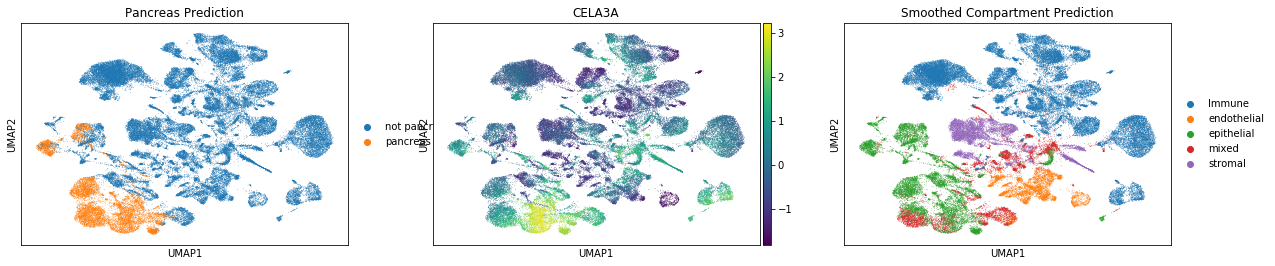

In [45]:
sc.pl.umap(new_adata, color=['Pancreas Prediction','CELA3A', 'Smoothed Compartment Prediction'])

... storing 'Manual Annotation Round 2' as categorical
... storing 'scANVI Prediction By Organ' as categorical
... storing 'scANVI Prediction By Organ-Compartment' as categorical
... storing 'tissue' as categorical
... storing 'scANVI Prediction By Organ with Alternate Training' as categorical
... storing 'scANVI Prediction By Organ-Compartment with Alternate Training' as categorical
... storing 'phase' as categorical
... storing 'scANVI Prediction Ontology Term By Organ' as categorical
... storing 'scANVI Prediction Ontology Term By Organ with Alternate Training' as categorical
... storing 'scANVI Prediction Ontology Term By Organ-Compartment' as categorical
... storing 'scANVI Prediction Ontology Term By Organ-Compartment with Alternate Training' as categorical
... storing 'Manual Annotation Round 2 Ontology Terms' as categorical


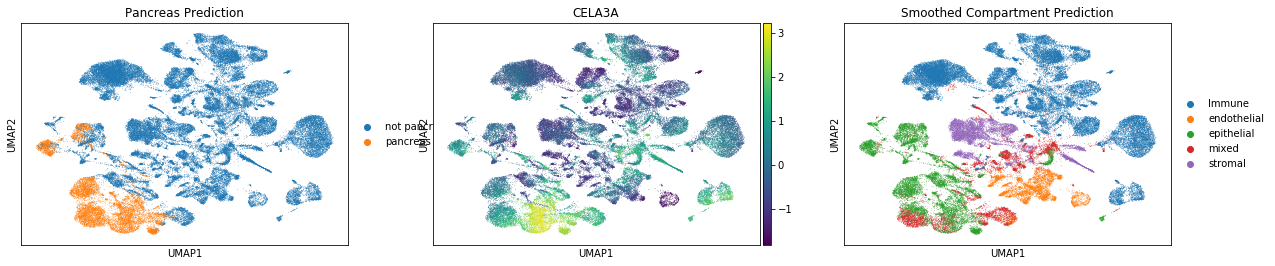

In [46]:
sc.pl.umap(imputed_adata, color=['Pancreas Prediction','CELA3A', 'Smoothed Compartment Prediction'])

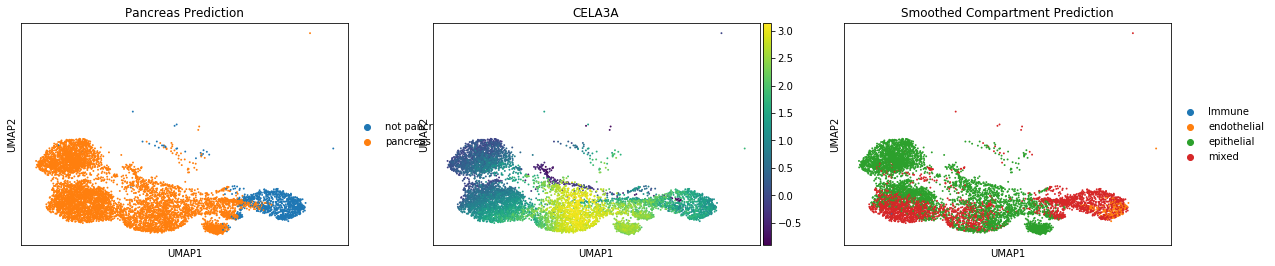

In [47]:
sc.pl.umap(imputed_adata[imputed_adata.obs['scANVI Prediction By Organ-Compartment with Alternate Training']=='pancreatic acinar cell'], color=['Pancreas Prediction','CELA3A', 'Smoothed Compartment Prediction'])

# write files

In [48]:
raw.write_h5ad('CombineCompartments.scANVI.all.count.h5ad')
imputed_adata.write_h5ad('CombineCompartments.scANVI.all.imputed.h5ad')
new_adata.write_h5ad('CombineCompartments.scANVI.all.scanpy_norm.h5ad')

... storing 'Manual Annotation Round 2' as categorical
... storing 'scANVI Prediction By Organ' as categorical
... storing 'scANVI Prediction By Organ-Compartment' as categorical
... storing 'tissue' as categorical
... storing 'scANVI Prediction By Organ with Alternate Training' as categorical
... storing 'scANVI Prediction By Organ-Compartment with Alternate Training' as categorical
... storing 'phase' as categorical
... storing 'scANVI Prediction Ontology Term By Organ' as categorical
... storing 'scANVI Prediction Ontology Term By Organ with Alternate Training' as categorical
... storing 'scANVI Prediction Ontology Term By Organ-Compartment' as categorical
... storing 'scANVI Prediction Ontology Term By Organ-Compartment with Alternate Training' as categorical
... storing 'Manual Annotation Round 2 Ontology Terms' as categorical


In [49]:
def SubsetWrite(adata, subset, filename):
    adata = adata[subset]
    if adata.shape[0]>0:
        print(filename)
        sc.pp.neighbors(adata, n_neighbors=20, n_pcs=30, use_rep="X_scvi")
        sc.tl.umap(adata)
        sc.tl.leiden(adata)
        sc.tl.tsne(adata, use_rep = 'X_scvi')
        adata.write_h5ad(filename)
    else:
        print("there is no cells to put in %s" %filename)
        
        
normalization_method = ['count', 'imputed','scanpy_norm']


In [ ]:
for comp in np.unique(raw.obs['Smoothed Compartment Prediction']):
    subset = raw.obs['Smoothed Compartment Prediction']==comp
    for norm, adata in zip(normalization_method, [raw, imputed_adata, new_adata]):
        SubsetWrite(adata, subset, 'CombineCompartments.scANVI.%s.%s.h5ad'%(comp, norm))
    

CombineCompartments.scANVI.Immune.count.h5ad
CombineCompartments.scANVI.Immune.imputed.h5ad
CombineCompartments.scANVI.Immune.scanpy_norm.h5ad
CombineCompartments.scANVI.endothelial.count.h5ad
CombineCompartments.scANVI.endothelial.imputed.h5ad
CombineCompartments.scANVI.endothelial.scanpy_norm.h5ad
CombineCompartments.scANVI.epithelial.count.h5ad
CombineCompartments.scANVI.epithelial.imputed.h5ad
CombineCompartments.scANVI.epithelial.scanpy_norm.h5ad
CombineCompartments.scANVI.mixed.count.h5ad
CombineCompartments.scANVI.mixed.imputed.h5ad
CombineCompartments.scANVI.mixed.scanpy_norm.h5ad


In [ ]:
for tissue in np.unique(raw.obs['tissue']):
    subset = raw.obs['tissue']==tissue
    for norm, adata in zip(normalization_method, [raw, imputed_adata, new_adata]):
        SubsetWrite(adata, subset, 'CombineCompartments.scANVI.%s.%s.h5ad'%(tissue, norm))
    

In [ ]:
for tissue in np.unique(raw.obs['tissue']):
    for comp in ['Endothelial', 'Epithelial', 'Immune', 'Stromal', 'mixed']:
        subset = np.logical_and(raw.obs['Smoothed Compartment Prediction']==comp, raw.obs['tissue']==tissue)
        for norm, adata in zip(normalization_method, [raw, imputed_adata, new_adata]):
            SubsetWrite(adata, subset, 'CombineCompartments.scANVI.%s.%s.%s.h5ad'%(tissue, comp, norm))

    

In [ ]:
subset = np.logical_or(raw.obs['Pancreas Prediction']=='pancreas', raw.obs['tissue']=='Pancreas')
for norm, adata in zip(normalization_method, [raw, imputed_adata, new_adata]):
    SubsetWrite(adata, subset, 'CombineCompartments.scANVI.%s.%s.h5ad'%('pancreas_all', norm))


# Generating DE results

In [ ]:
def DEbyCompartment(raw, full, label, split, filename, split_subset=None):
    if split_subset is None: 
        split_subset = np.unique(raw.obs[split])
    pred_label = np.asarray(raw.obs[label].values)
    pred_celltype, pred_label = np.unique(pred_label, return_inverse=True)
    for compartment in split_subset:
        writer = pd.ExcelWriter(compartment+'.'+filename, engine='xlsxwriter')
        print(compartment)
        de_res, de_cluster = full.one_vs_all_degenes(cell_labels=pred_label,
                                                     subset=raw.obs[split].values == compartment)

        for i, ct in enumerate(pred_celltype[de_cluster]):
            x = de_res[i]
            filt = np.logical_and(x['bayes_factor'].values > 1.3, x['raw_mean1'].values > 0.1)
            res = x.loc[filt]
            if len(ct)>31:
                ct = ct[:31]
            res.to_excel(writer, sheet_name=ct)
            res['celltype'] = ct
        writer.save()
    return( de_res, de_cluster)

In [ ]:
DEbyCompartment(raw, posterior, label='scANVI Prediction By Organ-Compartment',
               split ='Smoothed Compartment Prediction', filename='DE_OneVsCompartment.scANVI_by_OrganCompartment.xlsx')

In [ ]:
DEbyCompartment(raw, posterior, label='scANVI Prediction By Organ-Compartment',
               split ='Smoothed Compartment Prediction', filename='DE_OneVsCompartment.scANVI_by_OrganCompartment.xlsx')

In [ ]:
DEbyCompartment(raw, posterior, label='scANVI Prediction By Organ',
               split ='Smoothed Compartment Prediction', filename='DE_OneVsOrgan.scANVI_by_Organ.xlsx')

In [ ]:
DEbyCompartment(raw, posterior, label='scANVI Prediction By Organ-Compartment',
               split ='tissue', filename='DE_OneVsOrgan.scANVI_by_OrganCompartment.xlsx')